# Test Training with ResNet50


In this notebook, we will be exploring the capabilities of ResNet50 as well as summarising environmental implications. This will be achieved by utilising the pyiNaturalist API create our training dataset of 1000 images per animal species class. Transfer learning with the ResNet50 model, we will be validating our trained model with iNaturalist 2021 validation set, which has 10 images per species. The model is currently set to trained with 5 random animal species.

The notebook will also be split into three main parts:
1. Validating on resized images (which can be skewed)
2. Validating on cropped images
3. Understanding the effects utilising dropout and data augmentation

Please run the notebook sequentially.

# Load iNaturalist Training Dataset via API


To create our training data. We will be collecting 1000 images for 5 chosen species as the classes we want to retrain the model with.  The code was originally developed by another member of the intern team, [Efe](https://github.com/TotaalyNOTefexD).

## Imports

In [ ]:
import os
import requests
import pandas as pd
from PIL import Image
from io import BytesIO
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from tqdm import tqdm  # Progress bar

## Setup

In [ ]:
# List of species names to search for
species_names =  ['Panthera leo', 'Falco peregrinus', 'Oryx gazella', 'Zalophus wollebaeki', 'Rattus rattus']

# Maximum number of images to download for each species
max_images_per_species = 1000

In [ ]:
# Function to download and resize image
def download_and_resize_image(url, save_dir, obs_id, max_size=(180, 180)):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        img = img.resize(max_size)  # Resize image to the exact specified size

        # Ensure the save directory exists
        os.makedirs(save_dir, exist_ok=True)

        # Save the image with a unique name based on the observation ID
        img_name = f"{obs_id}.jpg"
        img_path = os.path.join(save_dir, img_name)
        img.save(img_path)
        return img_path
    except Exception as e:
        return None

## Downloading images

In [ ]:

session = requests.Session()
retry_strategy = Retry(
    total=3,
    status_forcelist=[429, 500, 502, 503, 504],
    backoff_factor=1
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session.mount('https://', adapter)

for species_name in species_names:
    try:
        # Directory to save images for the current species, change as needed
        save_dir = f'/home/DataSet/{species_name.replace(" ", "_")}_images'

        # Fetch taxon ID for the current species name
        search_response = session.get(f'https://api.inaturalist.org/v1/taxa?q={species_name}&rank=species', timeout=10).json()
        if not search_response['results']:
            print(f"No taxon found for species: {species_name}")
            continue

        # Assume the first result is the desired species
        taxon_id = search_response['results'][0]['id']

        observation_ids = []
        image_urls = []
        common_names = []
        scientific_names = []

        valid_image_count = 0

        # Fetch observations for the current species until the desired number of images is reached
        page = 1
        while valid_image_count < max_images_per_species:
            observations_response = session.get(
                f'https://api.inaturalist.org/v1/observations?taxon_id={taxon_id}&per_page=200&page={page}', timeout=10
            ).json()
            observations = observations_response['results']

            if not observations:
                break

            for observation in tqdm(observations, desc=f'Processing observations for {species_name}'):
                if valid_image_count >= max_images_per_species:
                    break

                # Extract and store observation details
                obs_id = observation['id']
                taxon = observation.get('taxon')
                if taxon:
                    common_name = taxon.get('preferred_common_name', 'No common name available')
                    scientific_name = taxon.get('name', 'No scientific name available')
                else:
                    common_name = 'No common name available'
                    scientific_name = 'No scientific name available'

                # Extract and store image data
                if 'observation_photos' in observation and observation['observation_photos']:
                    photo = observation['observation_photos'][0]['photo']
                    image_url = photo['url']
                    image_path = download_and_resize_image(image_url, save_dir=save_dir, obs_id=obs_id)
                    if image_path:
                        observation_ids.append(obs_id)
                        common_names.append(common_name)
                        scientific_names.append(scientific_name)
                        image_urls.append(image_url)
                        valid_image_count += 1

            page += 1

        # Create a DataFrame with observation details for the current species
        data = {
            'Observation ID': observation_ids,
            'Common Name': common_names,
            'Scientific Name': scientific_names,
            'Image URL': image_urls,
            'Image Path': [os.path.join(save_dir, f"{obs_id}.jpg") for obs_id in observation_ids]
        }
        df = pd.DataFrame(data)

        # Cap the dataset size to match the number of images available
        if valid_image_count < max_images_per_species:
            df = df.head(valid_image_count)

        # Save to a CSV file for the current species, change as needed
        csv_path = f'/home/{species_name.replace(" ", "_")}_dataset.csv'
        df.to_csv(csv_path, index=False)

        print(f"Data saved to {csv_path} for species: {species_name}")

    except requests.exceptions.HTTPError as e:
        print(f"HTTP error occurred: {e}")

Processing observations for Panthera leo:  28%|██▊       | 57/200 [00:21<00:54,  2.60it/s]


Data saved to /home/Panthera_leo_dataset.csv for species: Panthera leo


Processing observations for Falco peregrinus:  38%|███▊      | 75/200 [00:28<00:47,  2.65it/s]


Data saved to /home/Falco_peregrinus_dataset.csv for species: Falco peregrinus


Processing observations for Oryx gazella:  10%|▉         | 19/200 [00:07<01:11,  2.55it/s]


Data saved to /home/Oryx_gazella_dataset.csv for species: Oryx gazella


Processing observations for Zalophus wollebaeki:  16%|█▌        | 32/200 [00:11<01:02,  2.68it/s]


Data saved to /home/Zalophus_wollebaeki_dataset.csv for species: Zalophus wollebaeki


Processing observations for Rattus rattus:  10%|█         | 21/200 [00:07<01:07,  2.66it/s]

Data saved to /home/Rattus_rattus_dataset.csv for species: Rattus rattus


In [ ]:
# Count number of images downloaded
path = '/home/DataSet'
folders = os.listdir(path)
totalImages = 0
for folder in folders:
  images = os.listdir(f"{path}/{folder}")
  totalImages += len(images)

print(totalImages)

5000


# Load iNaturalist Validation Dataset via inat competition 2021

##Imports

In [ ]:
# For loading in dataset images and annotations
import json
import os

from etils import epath
import numpy as np
import tensorflow_datasets.public_api as tfds

# Displaying sample images
import itertools

import tarfile
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

##Setup

In [ ]:
dm = tfds.download.DownloadManager(download_dir='/home')

URL = 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021'    # endpoint to load images from

# maps split type to split file name
SPLIT_FILENAMES = {
    'train': 'train',
    'mini': 'train_mini',
    'val': 'val',
    'test': 'public_test',
}

# Only load validation set
SPLIT = 'val'
SPLIT_FILE = SPLIT_FILENAMES[SPLIT]

# maps dataset to split tar & json files
splitDownloads = {}


##Download

In [ ]:
# download image tar file
splitDownloads[f'{SPLIT}_img'] =  tfds.download.Resource(
          url=f'{URL}/{SPLIT_FILE}.tar.gz',
          extract_method=tfds.download.ExtractMethod.NO_EXTRACT,
      )
# download json annotation file
splitDownloads[f'{SPLIT}_json'] = f'{URL}/{SPLIT_FILE}.json.tar.gz'

print(splitDownloads)

outputPaths = dm.download_and_extract(splitDownloads)     # downloading the tar file containing validation images

{'val_img': <tensorflow_datasets.core.download.resource.Resource object at 0x79f4104000d0>, 'val_json': 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021/val.json.tar.gz'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

## Retrieving annotations from JSON file to load images from validation dataset


In [ ]:
# paths to loaded dataset

imagesArchive = outputPaths[f'{SPLIT}_img']
jsonFile = os.path.join(outputPaths[f'{SPLIT}_json'],f'{SPLIT_FILE}.json')

In [ ]:
with epath.Path(jsonFile).open('r') as f:
      inatJson = json.load(f)

In [ ]:
def format(label: str):
      # replace ' ' with '_' in a string
      return label.lower().replace(' ', '_')

# retrieves annotations (categories, id and image directory) for an image
def getAnnotation(idx, image_id):

      if 'annotations' in inatJson:

        # get the annotations object that matches our ID
        annotation = inatJson['annotations'][idx]
        assert annotation['image_id'] == image_id

        # retrieve 'categories' object corresponding to the id in the annotation object
        cat = inatJson['categories'][annotation['category_id']]

        # extract important metadata
        category = format(cat['name'])
        superCategory = format(cat['supercategory'])
        imageDirectory = cat['image_dir_name']

      else:
        # no metadata found
        category, superCategory, imageDirectory = -1, -1, -1

      return category, superCategory, imageDirectory

## Curating collection of annotated images

###Filtering

The code below allows us ensure that we only extract images related to vertebrates and our 5 selected species.

In [ ]:
# List containing the vertebrates recognised by iNaturalist Dataset
vertebrates = ["jawless_fishes", "hagfishes", "lampreys", "ray-finned_fishes", "amphibians", "birds", "elasmobranchs", "chimaeras", "mammals", "reptiles", "lobe-finned_fishes"]

In [ ]:
# List containing the animals that user want to see/train on
animalsToRetrieve = [format(name).lower() for name in species_names]      # formated so that images can be recognised
print(animalsToRetrieve)

['panthera_leo', 'falco_peregrinus', 'oryx_gazella', 'zalophus_wollebaeki', 'rattus_rattus']


###Map images to their annotations

In [ ]:
annotatedFiles = {}   # stores specified annotation and metadata of species

for idx, image in enumerate(inatJson['images']):

  category, superCategory, imageDirectory = getAnnotation(idx, image['id'])
  if (superCategory in vertebrates) and (category in animalsToRetrieve):      # Checking if the species is a vertebrate and checking latin name of the animal (using category)
    field = os.path.basename(image['file_name']).split('.')[0]

    annotatedFiles[field] = {
        'id': image['id'],
        'file_id': field,
        'label': category,      # latin name
        'superCategory': superCategory,
        'imagedirectory' : imageDirectory,
    }

In [ ]:
print(annotatedFiles)
print(len(annotatedFiles))


{'300262a5-cf42-4296-ad50-d9d305e19a80': {'id': 2687910, 'file_id': '300262a5-cf42-4296-ad50-d9d305e19a80', 'label': 'panthera_leo', 'superCategory': 'mammals', 'imagedirectory': '04682_Animalia_Chordata_Mammalia_Carnivora_Felidae_Panthera_leo'}, '68def9b7-2b36-4a03-800b-e13eea5b9f57': {'id': 2690192, 'file_id': '68def9b7-2b36-4a03-800b-e13eea5b9f57', 'label': 'rattus_rattus', 'superCategory': 'mammals', 'imagedirectory': '04815_Animalia_Chordata_Mammalia_Rodentia_Muridae_Rattus_rattus'}, 'b1acd7a9-9b88-4f90-a9ae-64cf3332ad89': {'id': 2690373, 'file_id': 'b1acd7a9-9b88-4f90-a9ae-64cf3332ad89', 'label': 'rattus_rattus', 'superCategory': 'mammals', 'imagedirectory': '04815_Animalia_Chordata_Mammalia_Rodentia_Muridae_Rattus_rattus'}, '9ba73392-081b-4813-bc2f-11bf64bf8a7d': {'id': 2690706, 'file_id': '9ba73392-081b-4813-bc2f-11bf64bf8a7d', 'label': 'zalophus_wollebaeki', 'superCategory': 'mammals', 'imagedirectory': '04710_Animalia_Chordata_Mammalia_Carnivora_Otariidae_Zalophus_wollebaeki'

## Extracting the images

In [ ]:
# image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(imagesArchive, 'r')

except IOError as e:
  print(e)

else:

  for id,value in annotatedFiles.items():
    # create image file path
    imgFilePath = f"val/{value['imagedirectory']}/{id}.jpg"         # specfying the file path to store the extracted images
    imgToExtract.append(imgFilePath)

  t.extractall('/home', members=imgToExtract)


#Validating with resized images

##Resizing and renaming

Since tensorflow does not allow flexible input sizes and images in the validation dataset can be of different dimensions, we need to resize all images to a resolution that also matches our training images. The resize function that we will be using, `im.resize` tends to skew and squash images if it's input image does not match the ratio of the output image.  

In [ ]:
from PIL import Image
import os,sys

# rename all folders to match class names of the training dataset
path = '/home/val'
dirs = os.listdir(path)

for folder in dirs:
  # rename species folder
  os.rename(f"{path}/{folder}", f"{path}/{'_'.join(folder.split('_')[6::])}_images")

  # get path of each image in class folder
  new_path = f"{path}/{'_'.join(folder.split('_')[6::])}_images"
  image_dir = os.listdir(new_path)

  for item in image_dir:
    item_path = f"{new_path}/{item}"

    if os.path.isfile(item_path):
      im = Image.open(item_path)
      f, e = os.path.splitext(item_path)
      imResize = im.resize((180,180))     # resizing image so that it can be read by the model
      imResize.save(item_path,'JPEG', quality=90)

## Building the Model

###Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

###Quick check

In [ ]:
import pathlib
data_dir = pathlib.Path('/home/DataSet').with_suffix('')      # directory that stores the training data

# image count
imageCount = len(list(data_dir.glob('*/*.jpg')))

### Preprocessing / Creating dataset

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=None,
  subset = None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5000 files belonging to 5 classes.


In [ ]:
# Identifying class names that model has to train for. These the species the user selected to train on.
class_names = train_ds.class_names
print(class_names)

['Falco_peregrinus_images', 'Oryx_gazella_images', 'Panthera_leo_images', 'Rattus_rattus_images', 'Zalophus_wollebaeki_images']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
# Creating the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/home/val',
  validation_split=None,
  subset = None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 50 files belonging to 5 classes.


### Configuring dataset for performance

In [ ]:
# Prefetching and caching the datasets to memory
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standarise data

RGB channel values are in the range `[0,255]`. But this is not ideal for NN, so need to make input values small.

Use `tf.keras.layers.Rescaling` to standardise values to `[0,1]` range.

In [ ]:
normalization_layer = layers.Rescaling(1./255)

### Creating the Model



In [ ]:
from tensorflow.keras.applications import ResNet50

num_classes = len(class_names)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pretrained weights
resnet50_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))
x = resnet50_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)


94765736/94765736 [==============================] - 3s 0us/step


##Compile the Model

Optimizer is `tf.keras.optimizers.Adam`\
Loss function is `tf.keras.losses.SparseCategoricalCrossEntropy`

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model Summary

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


## Training of Model

In [ ]:
# using 10 epochs of size 32 and with model.fit method

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
157/157 [==============================] - 283s 2s/step - loss: 0.7055 - accuracy: 0.7472 - val_loss: 0.5144 - val_accuracy: 0.8200
Epoch 2/10
157/157 [==============================] - 275s 2s/step - loss: 0.4125 - accuracy: 0.8526 - val_loss: 0.4131 - val_accuracy: 0.8200
Epoch 3/10
157/157 [==============================] - 272s 2s/step - loss: 0.3343 - accuracy: 0.8838 - val_loss: 0.5373 - val_accuracy: 0.8200
Epoch 4/10
157/157 [==============================] - 283s 2s/step - loss: 0.2889 - accuracy: 0.9034 - val_loss: 0.5341 - val_accuracy: 0.8200
Epoch 5/10
157/157 [==============================] - 274s 2s/step - loss: 0.2509 - accuracy: 0.9184 - val_loss: 0.6215 - val_accuracy: 0.7800
Epoch 6/10
157/157 [==============================] - 283s 2s/step - loss: 0.2240 - accuracy: 0.9306 - val_loss: 0.5470 - val_accuracy: 0.8600
Epoch 7/10
157/157 [==============================] - 273s 2s/step - loss: 0.1994 - accuracy: 0.9386 - val_loss: 0.6010 - val_accuracy: 0.8400

## Visualising training results

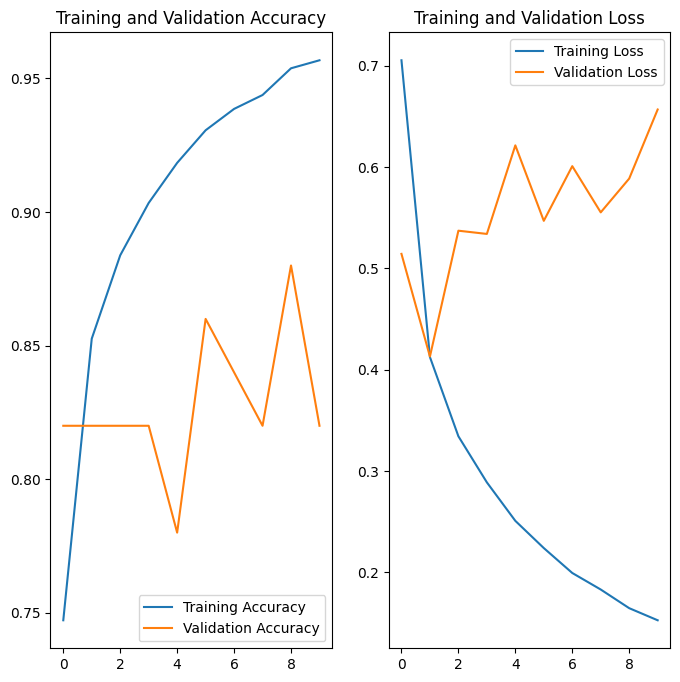

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation

###Initial model findings:
This is an evaluation completed by another intern when transfer learning with ResNet50 using only 100 images per species for 5 species in the training dataset. The validation loss does not increase as training loss decreases, after 3 epochs it grows more consistent.

###Current model findings:
Peak Training acc: 95%
Peak Validation acc: 87.5%
As the training loss decreases over the number of 10 epochs, the validation loss seems to settle between 0.65 and 0.54 after 2 epochs. It does not seem to indicate signs of overfitting as the validation loss does not increase.


#Validating with cropped images instead of resized

To understand the true effects of how validation performance is affected by how validation images are preprocessed for input. We will be trying another method of resizing where all images will be cropped centrally to a 1:1 ratio.

### Extract validation images again


####imports

In [ ]:
from PIL import Image
import os,sys
import tarfile

####Extracting

In [ ]:
# image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(imagesArchive, 'r')

except IOError as e:
  print(e)

else:

  for id,value in annotatedFiles.items():
    # create image file path
    imgFilePath = f"val/{value['imagedirectory']}/{id}.jpg"
    imgToExtract.append(imgFilePath)

  t.extractall('/home/val2.0', members=imgToExtract)      # download the new images to another folder


### Cropping the validation images

In [ ]:
# rename all folders
path = '/home/val2.0/val'
dirs = os.listdir(path)

for folder in dirs:
  # rename folders so class folders match the names of the training dataset
  os.rename(f"{path}/{folder}", f"{path}/{'_'.join(folder.split('_')[6::])}_images")

  # get new path to manipulate images
  new_path = f"{path}/{'_'.join(folder.split('_')[6::])}_images"
  image_dir = os.listdir(new_path)

  for item in image_dir:
    # full image path
    item_path = f"{new_path}/{item}"

    if os.path.isfile(item_path):
      print(f"Currently manipulating {item}")
      im = Image.open(item_path)

      # cropping the images to square aspect ratio
      width, height = im.size
      min_dimension = min(width, height)
      # left(x), upper(y), right(x), lower(y)
      img_mid_area = ((width - min_dimension) // 2,
                      (height - min_dimension) // 2,
                      ((width - min_dimension) // 2) + min_dimension,
                       ((height - min_dimension) // 2) + min_dimension)
      img_cropped = im.crop(img_mid_area)

      # resize square cropped images to 180x180px
      imResize = img_cropped.resize((180,180))

      imResize.save(item_path,'JPEG', quality=90)


Currently manipulating 5dcbbcf8-e1b8-400b-b834-5c1e86885cff.jpg
Currently manipulating bcbf1577-1003-4103-8f52-5cea72d5cd96.jpg
Currently manipulating ae9adbce-1809-4263-8737-020aee79e657.jpg
Currently manipulating 4c0bfdd5-816c-45f4-b637-89d06f7ee157.jpg
Currently manipulating 8eb3b671-6ff9-4e0f-8367-4751570621e7.jpg
Currently manipulating b0f0d610-5aba-4df0-86ed-6594e43b567f.jpg
Currently manipulating 83b87a73-0f1c-4bf0-9220-86d5789626d9.jpg
Currently manipulating ca25da17-453a-472f-b0b1-8c46a36b2948.jpg
Currently manipulating 300262a5-cf42-4296-ad50-d9d305e19a80.jpg
Currently manipulating 25b3ef16-2528-409f-ba37-0b4e0bb92d2d.jpg
Currently manipulating ecf22b4b-8574-4e9e-a086-80f9979f845e.jpg
Currently manipulating 9ba73392-081b-4813-bc2f-11bf64bf8a7d.jpg
Currently manipulating d0c54f2e-3fad-43a6-b10f-b7915f6e9f4b.jpg
Currently manipulating 900b7f0a-ce1e-458e-9051-2c386c5de384.jpg
Currently manipulating 9d3b2b09-cfb5-4443-8f78-021a49af8b43.jpg
Currently manipulating 5291b5fc-3a96-4f4

###Model setup

In [ ]:
# Creating the validation dataset
val_ds2 = tf.keras.utils.image_dataset_from_directory(
  '/home/val2.0/val',
  validation_split=None,
  subset = None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 50 files belonging to 5 classes.


In [ ]:
# Reinitialising the training dataset (incase)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=None,
  subset = None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5000 files belonging to 5 classes.


####Configuring dataset for performance

In [ ]:
# Prefetching and caching the datasets to memory
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds2 = val_ds2.cache().prefetch(buffer_size=AUTOTUNE)

####Normalisating

In [ ]:
normalization_layer = layers.Rescaling(1./255)

###Creating the Model

In [ ]:
from tensorflow.keras.applications import ResNet50

num_classes = len(class_names)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pretrained weights
resnet50_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))
x = resnet50_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


###Training (and Validating) the Model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds2,
  epochs=epochs
)

Epoch 1/10
157/157 [==============================] - 285s 2s/step - loss: 0.6669 - accuracy: 0.7540 - val_loss: 0.6833 - val_accuracy: 0.7400
Epoch 2/10
157/157 [==============================] - 284s 2s/step - loss: 0.3971 - accuracy: 0.8644 - val_loss: 0.6238 - val_accuracy: 0.7000
Epoch 3/10
157/157 [==============================] - 276s 2s/step - loss: 0.3252 - accuracy: 0.8942 - val_loss: 0.6200 - val_accuracy: 0.7000
Epoch 4/10
157/157 [==============================] - 283s 2s/step - loss: 0.2862 - accuracy: 0.9026 - val_loss: 0.5623 - val_accuracy: 0.7400
Epoch 5/10
157/157 [==============================] - 276s 2s/step - loss: 0.2506 - accuracy: 0.9194 - val_loss: 0.5474 - val_accuracy: 0.7600
Epoch 6/10
157/157 [==============================] - 283s 2s/step - loss: 0.2249 - accuracy: 0.9268 - val_loss: 0.6612 - val_accuracy: 0.7000
Epoch 7/10
157/157 [==============================] - 282s 2s/step - loss: 0.1981 - accuracy: 0.9378 - val_loss: 0.6285 - val_accuracy: 0.7000

###Visualising training results

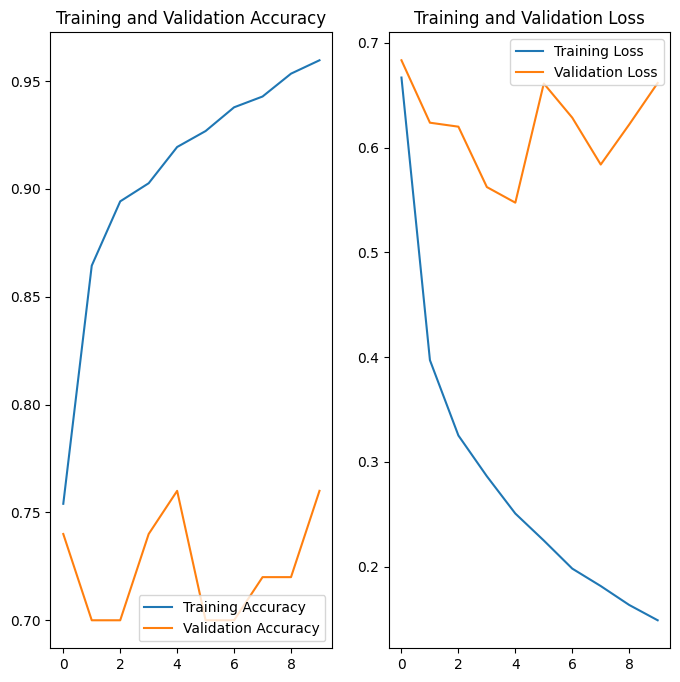

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Evaluation

Peak Training acc: 95%
Peak Validation acc: 76%

Interestingly, the validation performance seem to worsen. As the validation loss seemed to slowly increase as the number of epochs increase, all the while the training loss seems to decrease at an almost exponential rate. This seemed to indicate some sort of overfitting, this seemed to be an anomoly, as when we resized the same validation images in our inital model the validation loss was consistent.

This indicates the way that images are preprocessed affect it's validation performance. The results were also surprising as the training images were not skewed in any way as the API downloads them to a 1:1 ratio.

# Experimenting with Overfitting methods

Let's try applying methods of dealing with overfitting with both our resized validation dataset and the cropped validation dataset.

##Initialising Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

View augmented examples:

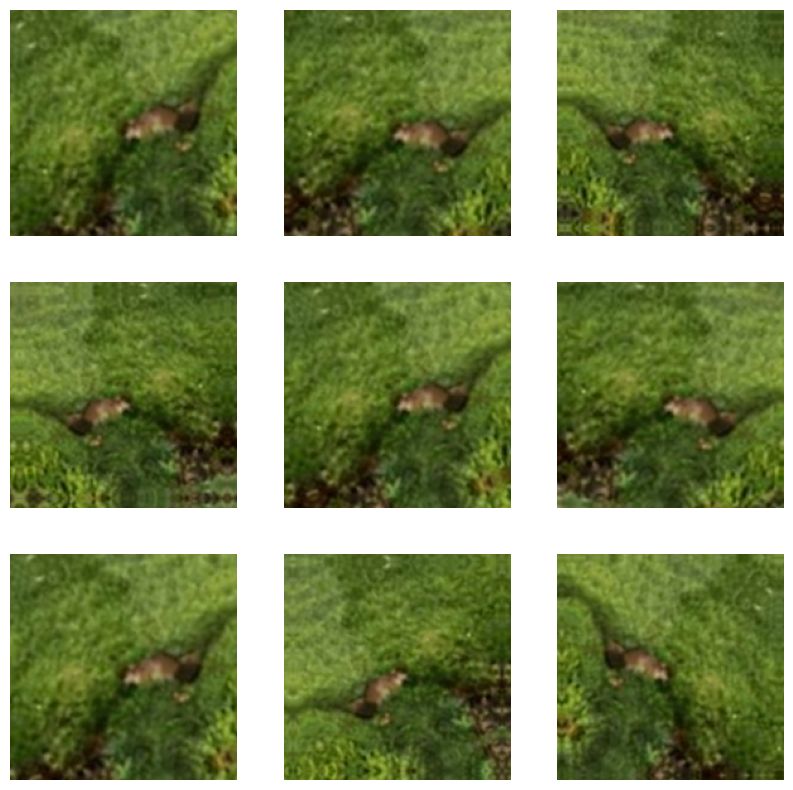

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

##Compile and training the new tuned model for resized images

### Dropout and Model

Applying dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value.

After applying dropout to ResNet50 before training it using the augmented images:

In [ ]:
from tensorflow.keras.applications import ResNet50

resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

resnet50_model.trainable = False

model = Sequential()
model.add(data_augmentation)
model.add(resnet50_model)
model.add(layers.Dropout(0.2))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(num_classes, name="outputs"))




In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 6, 6, 2048)        0         
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 outputs (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
157/157 [==============================] - 297s 2s/step - loss: 0.8213 - accuracy: 0.6918 - val_loss: 0.5226 - val_accuracy: 0.8200
Epoch 2/15
157/157 [==============================] - 297s 2s/step - loss: 0.5420 - accuracy: 0.8076 - val_loss: 0.5403 - val_accuracy: 0.7200
Epoch 3/15
157/157 [==============================] - 291s 2s/step - loss: 0.4842 - accuracy: 0.8222 - val_loss: 0.4673 - val_accuracy: 0.7800
Epoch 4/15
157/157 [==============================] - 291s 2s/step - loss: 0.4320 - accuracy: 0.8378 - val_loss: 0.5740 - val_accuracy: 0.8000
Epoch 5/15
157/157 [==============================] - 291s 2s/step - loss: 0.4102 - accuracy: 0.8544 - val_loss: 0.4486 - val_accuracy: 0.8400
Epoch 6/15
157/157 [==============================] - 292s 2s/step - loss: 0.3854 - accuracy: 0.8572 - val_loss: 0.4631 - val_accuracy: 0.8600
Epoch 7/15
157/157 [==============================] - 290s 2s/step - loss: 0.3714 - accuracy: 0.8648 - val_loss: 0.4187 - val_accuracy: 0.8600

### Visualise training results

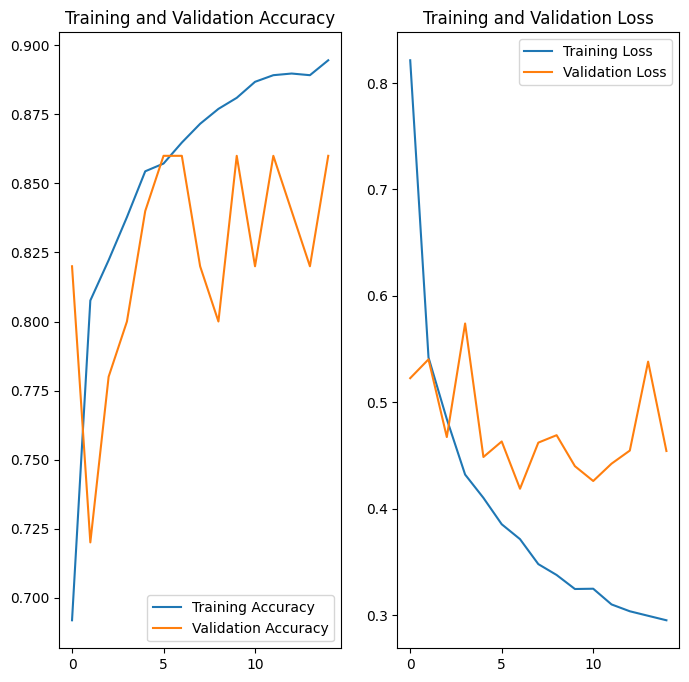

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Evaluation

From the graphs above, we can observe the peak accuracies of 89% and 86% for training and validation over 15 epochs. While as the number of epochs increased, the validation loss subtly decreased from 0.5226 to 0.4542. With the training loss exponentially decreasing to 0.2951.

This is a strong contrast to our initial model validated with resized images. Although the training peak training accuracy was higher (95%) than this model, the latter had a lower validation peak accuracy. Furthermore, in this model we can observe that the validation loss subtly decreases over epochs, contrasting our initial model where we saw validation loss increasing over epochs.

Hence we can conclude, overfitting methods help decrease validation losses, however training accuracy increases at a lower rate over epochs.

##Compile and training the new tuned model for cropped images

### Dropout and Model

Applying dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value.

After applying dropout to ResNet50 before training it using the augmented images:

In [ ]:
from tensorflow.keras.applications import ResNet50

resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

resnet50_model.trainable = False

model = Sequential()
model.add(data_augmentation)
model.add(resnet50_model)
model.add(layers.Dropout(0.2))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(num_classes, name="outputs"))




In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 2048)        0         
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 outputs (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds2,
  epochs=epochs
)

Epoch 1/15
157/157 [==============================] - 291s 2s/step - loss: 0.7940 - accuracy: 0.7056 - val_loss: 0.6596 - val_accuracy: 0.7200
Epoch 2/15
157/157 [==============================] - 287s 2s/step - loss: 0.5321 - accuracy: 0.8086 - val_loss: 0.5870 - val_accuracy: 0.7800
Epoch 3/15
157/157 [==============================] - 285s 2s/step - loss: 0.4763 - accuracy: 0.8304 - val_loss: 0.6936 - val_accuracy: 0.7800
Epoch 4/15
157/157 [==============================] - 285s 2s/step - loss: 0.4395 - accuracy: 0.8404 - val_loss: 0.5388 - val_accuracy: 0.7600
Epoch 5/15
157/157 [==============================] - 285s 2s/step - loss: 0.3983 - accuracy: 0.8600 - val_loss: 0.6144 - val_accuracy: 0.7600
Epoch 6/15
157/157 [==============================] - 285s 2s/step - loss: 0.3774 - accuracy: 0.8662 - val_loss: 0.6514 - val_accuracy: 0.7400
Epoch 7/15
157/157 [==============================] - 287s 2s/step - loss: 0.3675 - accuracy: 0.8700 - val_loss: 0.6326 - val_accuracy: 0.7400

### Visualise training results

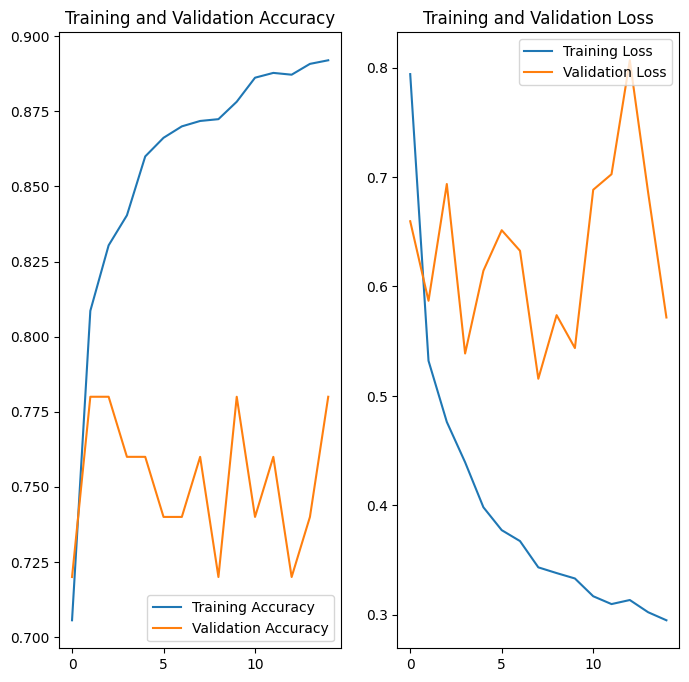

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Evaluation
From the graphs above, we can observe the peak accuracies of 89% and 78% for training and validation over 15 epochs. While as the number of epochs increased, the validation loss increase and decreased inconsistently. With the training loss exponentially decreasing to 0.2951.

This contrasts to our initial model validated with cropped images. Although the training peak training accuracy was higher (95%) than this model, the latter ended a lower validation accuracy. Furthermore, we can observe that the validation loss in both models across different epochs is quite inconsistent in rate. However, the peak validation rate for the initial model is slightly lower than our current model by 2%.

Hence we can conclude, overfitting methods upon validating centrally cropped images does not change training accuracies as expected. The behaviour of validation losses and accuracies were very similar.



#Conclusion
Throughout this notebook we have experimented with training with a larger dataset, along with experimenting the affected validation statistics based on cropping or resizing images.

From the numerous evaluations and statistics drawn, we can conclude that when training with images were correctly resized without skew, validation accuracies and losses perform better when validation images are resized with skew. In comparision to when the model is validated against images that were centrally cropped without skew. 8% difference in peak validation accuracies.

This result is peculiar as compared to some brief [research](https://forums.fast.ai/t/impact-of-image-resizing-on-model-training-time-and-performance/1980) and [queries](https://stackoverflow.com/questions/47697622/cnn-image-resizing-vs-padding-keeping-aspect-ratio-or-not) from others, where others have found validation accuracy of a model trained with centrally cropped images to perform the highest. It was also suggested by Jeremy Howard that padding a big piece of the image could have an effect where the CNN will have to learn that the black part of the image is not relevant and does not help distinguishing between classes. Though it could take some epochs. However, this is another aspect of preprocessing we can experiment with.

Finally, the cost of a complete run of the notebook costs £1.02. The production of this whole notebook which includes over 10+ runs averaged out to a cost of £10.39 services from Colab Enterprise.